In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


## LAG ANALYSI

In [2]:
data_week = pd.read_csv('data_per_week.csv')
data_week.head()

quantity  price_per_item  freight_per_item  review  \
0         1           29.99              7.78     5.0   
1         0            0.00              0.00     0.0   
2         1           29.99              7.78     4.0   
3         0            0.00              0.00     0.0   
4         0            0.00              0.00     0.0   

                         product_id  order_price  order_freight  total_price  \
0  87285b34884572647811a353c7ac498a        29.99           7.78        37.77   
1  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   
2  87285b34884572647811a353c7ac498a        29.99           7.78        37.77   
3  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   
4  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   

    ANO  MÊS           ...             12 MESES_ipca  Taxa (% a.a.)_selic  \
0  2017    8           ...                      2,46             8.872222   
1  2017    8           ...                      2,46             8.872222   
2  2017    8           ...                      2,46             8.872222   
3  2017    8           ...                      2,46             8.872222   
4  2017    9           ...                      2,54             8.165625   

   Fator diário_selic  Financeiro (R$)_selic  Operações_selic  Média_selic  \
0            1.000337           3.716054e+11       979.833333     8.872222   
1            1.000337           3.716054e+11       979.833333     8.872222   
2            1.000337           3.716054e+11       979.833333     8.872222   
3            1.000337           3.716054e+11       979.833333     8.872222   
4            1.000312           4.348451e+11       937.125000     8.165625   

  Mediana_selic  Moda_selic  Desvio padrão_selic  Índice de curtose_selic  
0      8.862222    8.872222             0.023889              1355.101667  
1      8.862222    8.872222             0.023889              1355.101667  
2      8.862222    8.872222             0.023889              1355.101667  
3      8.862222    8.872222             0.023889              1355.101667  
4      8.155625    8.165625             0.021875              1626.833750  

[5 rows x 32 columns]

In [3]:
auto_corr_list = []
for i in range(20):
    auto_corr_list.append(data_week.quantity.autocorr(lag=i))

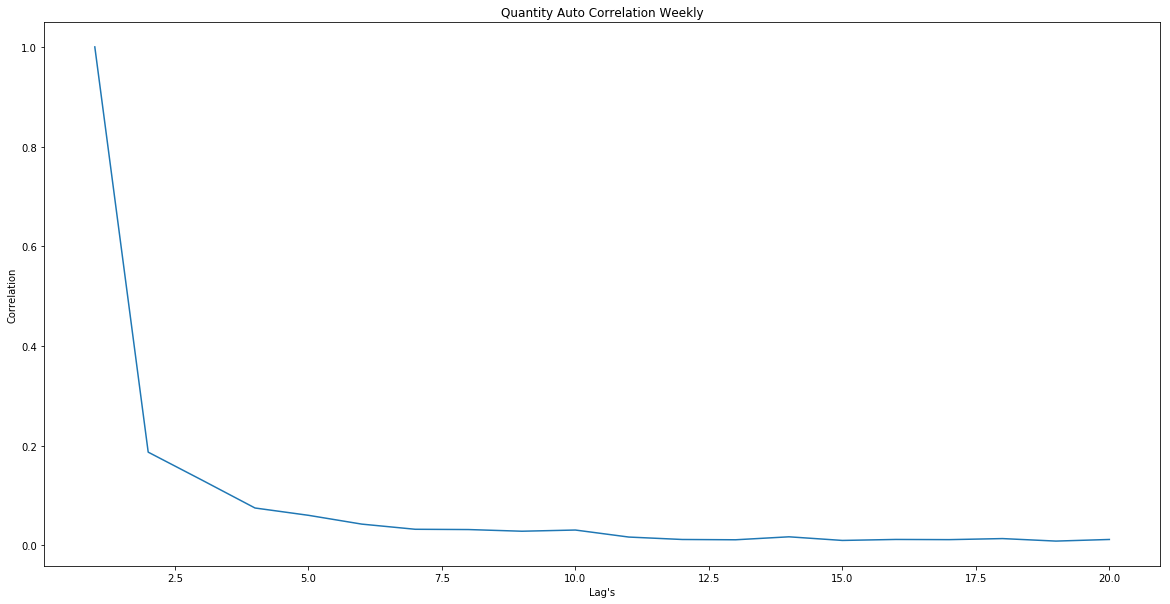

In [13]:
plt.figure(figsize=(20,10))
plt.plot(range(1,21),auto_corr_list)
plt.title('Quantity Auto Correlation Weekly')
plt.xlabel('Lag\'s')
plt.ylabel('Correlation')
plt.savefig('autocorrelation_weekly.png')

In [7]:
data_month = pd.read_csv('data_per_month.csv')
data_month.head()

Unnamed: 0  12 MESES_inpc 12 MESES_ipca  3 MESES_inpc  3 MESES_ipca  \
0           0           1.73          2,46         -0.16          0.20   
1           1           1.83          2,70          0.32          0.77   
2           0           1.73          2,46         -0.16          0.20   
3           1           1.63          2,54          0.12          0.59   
4           2           1.83          2,70          0.32          0.77   

   6 MESES_inpc 6 MESES_ipca     ANO  Desvio padrão_selic  Fator diário_selic  \
0          0.60         0,90  2017.0             0.023889            1.000337   
1          0.55         1,09  2017.0             0.030000            1.000309   
2          0.60         0,90  2017.0             0.023889            1.000337   
3          0.26         0,81  2017.0             0.021875            1.000312   
4          0.55         1,09  2017.0             0.030000            1.000309   

            ...                   date  freight_per_item  order_freight  \
0           ...             2017-08-01              7.78           7.78   
1           ...             2017-10-01             11.41          11.41   
2           ...             2017-08-01             15.75          15.75   
3           ...             2017-09-01              9.19           9.19   
4           ...             2017-10-01             17.15          17.15   

   order_price  price_per_item                        product_id  quantity  \
0        29.99           29.99  87285b34884572647811a353c7ac498a       1.0   
1        29.99           29.99  87285b34884572647811a353c7ac498a       1.0   
2       142.50          142.50  595fac2a385ac33a80bd5114aec74eb8       1.0   
3       142.50          142.50  595fac2a385ac33a80bd5114aec74eb8       1.0   
4       142.50          142.50  595fac2a385ac33a80bd5114aec74eb8       1.0   

   review  total_price  Índice de curtose_selic  
0     4.5        37.77              1355.101667  
1     3.5        41.40              1161.462353  
2     3.0       158.25              1355.101667  
3     1.0       151.69              1626.833750  
4     5.0       159.65              1161.462353  

[5 rows x 33 columns]

In [8]:
auto_corr_list = []
for i in range(20):
    auto_corr_list.append(data_month.quantity.autocorr(lag=i))

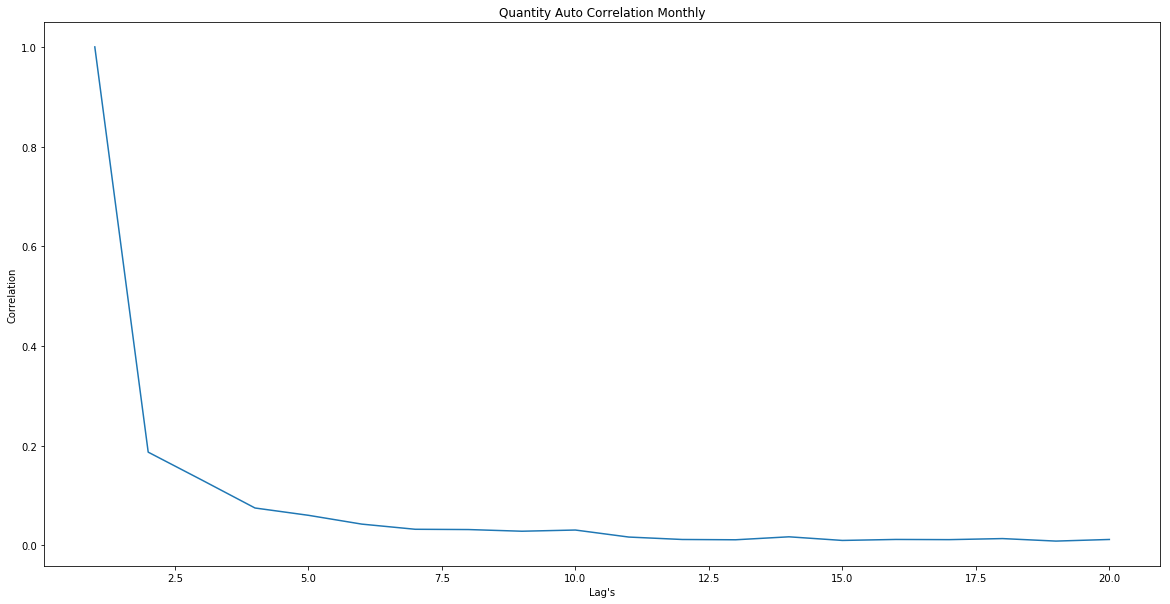

In [12]:
plt.figure(figsize=(20,10))
plt.plot(range(1,21),auto_corr_list)
plt.title('Quantity Auto Correlation Monthly')
plt.xlabel('Lag\'s')
plt.ylabel('Correlation')
plt.savefig('autocorrelation_monthly.png')

In [3]:
prod1 = pd.read_csv('./processed_data/prod1_per_week.csv')
#prod1 = prod1.drop('time',axis=1)

In [8]:
prod1.shape

(38, 8)

In [25]:
pd.to_datetime(prod1.time,yearfirst=True,format="%Y-%M-%w")

ValueError: unconverted data remains: 4/2017-07-30

In [29]:
pd.period_range(start=prod1.time.min(),end=prod1.time.max(),freq='W')

PeriodIndex(['2017-07-24/2017-07-30', '2017-07-31/2017-08-06',
             '2017-08-07/2017-08-13', '2017-08-14/2017-08-20',
             '2017-08-21/2017-08-27', '2017-08-28/2017-09-03',
             '2017-09-04/2017-09-10', '2017-09-11/2017-09-17',
             '2017-09-18/2017-09-24', '2017-09-25/2017-10-01',
             '2017-10-02/2017-10-08', '2017-10-09/2017-10-15',
             '2017-10-16/2017-10-22', '2017-10-23/2017-10-29',
             '2017-10-30/2017-11-05', '2017-11-06/2017-11-12',
             '2017-11-13/2017-11-19', '2017-11-20/2017-11-26',
             '2017-11-27/2017-12-03', '2017-12-04/2017-12-10',
             '2017-12-11/2017-12-17', '2017-12-18/2017-12-24',
             '2017-12-25/2017-12-31', '2018-01-01/2018-01-07',
             '2018-01-08/2018-01-14', '2018-01-15/2018-01-21',
             '2018-01-22/2018-01-28', '2018-01-29/2018-02-04',
             '2018-02-05/2018-02-11', '2018-02-12/2018-02-18',
             '2018-02-19/2018-02-25', '2018-02-26/2018-

In [15]:
pd.date_range(start=prod1.time.min(),end=prod1.time.max(),freq='W', tz=)

TypeError: Start and end cannot both be tz-aware with different timezones

In [3]:
prod2 = pd.read_csv('./processed_data/prod2_per_week.csv')
prod2.shape

(74, 8)

In [94]:
# convert an array of values into a dataset matrix
def create_window_dataset(dataset, look_back=1):
    dataX = [[] for _ in dataset]
    dataY = [[] for _ in dataset]
    for i in range(look_back,len(dataset)):
        dataY[i].append(dataset[i][0])
        for j in range(look_back):
            dataX[i].append((dataset[i-(j+1)]))
    return np.asarray(dataX[look_back:]), np.asarray(dataY[look_back:])

In [95]:
def df_to_np(dataframe):
    # load the dataset
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(-1, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train, test


In [96]:
train, test = df_to_np(prod1)
train.shape

(30, 7)

In [101]:
np.random.seed(7)
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_window_dataset(train, look_back)
testX, testY = create_window_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX.shape

(26, 4, 7)

In [130]:
#LSTM Autoencoder, take 1 :)
#if we take a brief look up, we can see TrainX shape.

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

latent_dim = 30
input_dim = 7
timesteps = look_back

inputs = Input(shape=(timesteps, input_dim))
pre_encoded = LSTM(2*latent_dim, return_sequences=True)(inputs)
encoded = LSTM(latent_dim)(pre_encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)
#entender Modelo
sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

sequence_autoencoder.fit(trainX, trainX, batch_size=1, epochs=1500, verbose=2)

Epoch 1/1500
 - 5s - loss: 0.2595
Epoch 2/1500
 - 0s - loss: 0.1926
Epoch 3/1500
 - 0s - loss: 0.1786
Epoch 4/1500
 - 0s - loss: 0.1700
Epoch 5/1500
 - 0s - loss: 0.1653
Epoch 6/1500
 - 0s - loss: 0.1580
Epoch 7/1500
 - 0s - loss: 0.1537
Epoch 8/1500
 - 0s - loss: 0.1503
Epoch 9/1500
 - 0s - loss: 0.1469
Epoch 10/1500
 - 0s - loss: 0.1465
Epoch 11/1500
 - 0s - loss: 0.1449
Epoch 12/1500
 - 0s - loss: 0.1443
Epoch 13/1500
 - 0s - loss: 0.1426
Epoch 14/1500
 - 0s - loss: 0.1424
Epoch 15/1500
 - 0s - loss: 0.1410
Epoch 16/1500
 - 0s - loss: 0.1400
Epoch 17/1500
 - 0s - loss: 0.1392
Epoch 18/1500
 - 0s - loss: 0.1383
Epoch 19/1500
 - 0s - loss: 0.1374
Epoch 20/1500
 - 0s - loss: 0.1373
Epoch 21/1500
 - 0s - loss: 0.1365
Epoch 22/1500
 - 0s - loss: 0.1355
Epoch 23/1500
 - 0s - loss: 0.1355
Epoch 24/1500
 - 0s - loss: 0.1347
Epoch 25/1500
 - 0s - loss: 0.1341
Epoch 26/1500
 - 0s - loss: 0.1338
Epoch 27/1500
 - 0s - loss: 0.1332
Epoch 28/1500
 - 0s - loss: 0.1326
Epoch 29/1500
 - 0s - loss: 0

In [136]:
x = trainX
xhat2 = sequence_autoencoder.predict(x)

sequence_autoencoder.save('autoencoder1500epochs.h5')


In [132]:
trainX[20]

array([[-0.44680852, -0.52353835, -0.1508835 ,  0.14285707, -0.44852066,
        -0.49863023, -0.46029246],
       [-0.36170214, -0.5024049 , -0.02916729,  0.16666651, -0.36367768,
        -0.3524289 , -0.36313176],
       [-0.57446814, -0.5696473 ,  0.03935504, -0.3333335 , -0.5757851 ,
        -0.5078519 , -0.56422037],
       [-0.02127659, -0.748961  , -0.04087341, -0.69444466, -0.02430582,
         0.09346414, -0.00213718]], dtype=float32)